## Daniel Burke 12067717 Etivity 2

### Task One - Data Preparation Pipeline

This is the same dataset that we used in e-tivity 1. In this e-tivity, the goal is to apply a clustering algorithm to the bank dataset, but first of all we want to restructure the data preparation done in e-tivity 1 as a data preparation pipeline. - Notes taken from the provided Tutorial 2.


In [1]:
#A. Import Python Modules and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder #needed for data preparation
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from sklearn.datasets import make_blobs

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
current_palette = sns.color_palette('Set2')

In [2]:
# Load the dataset
df = pd.read_csv("./bank.csv")
df_original = df.copy() # make a copy

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


In [3]:
FEATURES = list(df.columns.values)
print(FEATURES)


CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
print(CATEGORICAL_FEATURES)

NUMERICAL_FEATURES = df.select_dtypes(exclude=['object']).columns.tolist()
print(NUMERICAL_FEATURES)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'subscribed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'subscribed']
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
# B. Exploratory Data Analysis and Data Preparation
df.info()
#df.select_dtypes(exclude=['object'])

#### Question: How to restructure the data preparation of the bank dataset as a scikit-learn pipeline?

I have had a quick look at the data here using some of the EDA techniques used in Etivity 1. This time I am using a pipeline in order to wrangle the data into the correct format, before I start the machine learning techniques.

Below, I will speak in detail about the pipeline itself.

First I am going to do some quick plots to visualize the outliers and the skew for the numerical features before I run the pipeline, and then I am going to redo some plots below and see if they have been removed effectively and correctly by the pipeline. This was redone many times before and after the cluster analysis in section two below, to make as sure as I can that I am dealing with the columns in the pipeline as best I can.

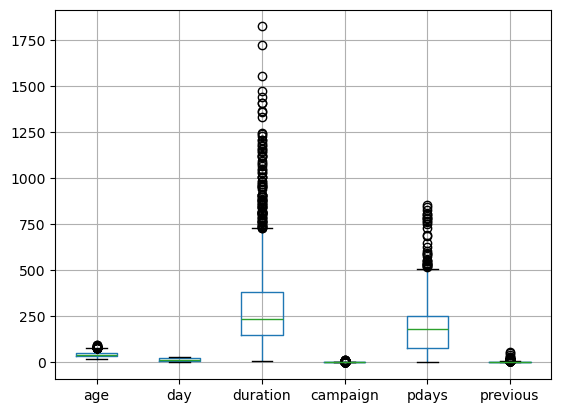

In [37]:
df_original.drop('balance', axis=1).boxplot() 

plt.show()

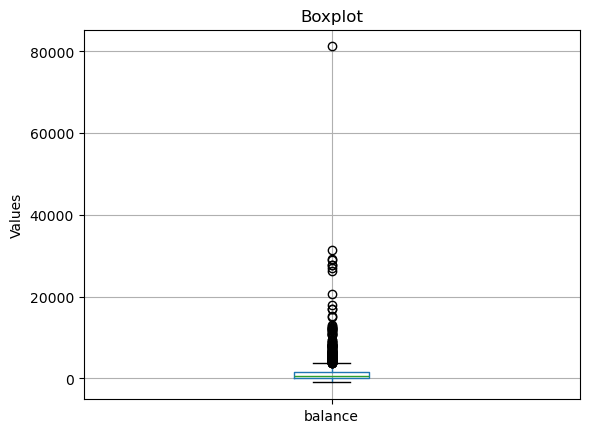

In [38]:
df_original[['balance']].boxplot()

plt.title('Boxplot')
plt.ylabel('Values')
plt.show()

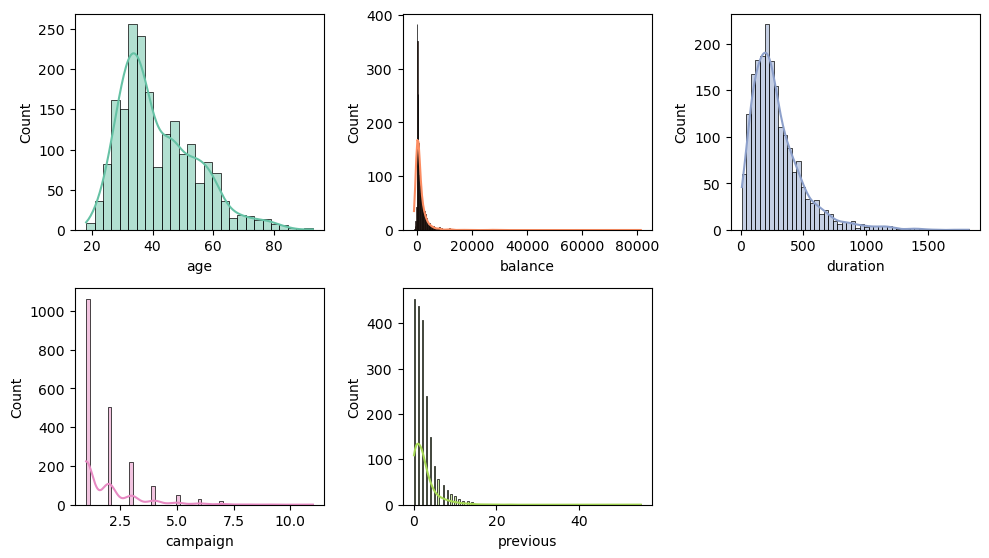

Skewness    Kurtosis
age        0.853921    0.390934
balance   11.461564  231.856074
day        0.403661   -1.285034
duration   2.045787    6.297587
campaign   2.320856    7.162811
pdays      0.920006    2.710735
previous   5.461168   59.746704

In [39]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(NUMERICAL_FEATURES, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_original[col], kde=True, stat="count", linewidth=0.5, color=current_palette[i-1])
    plt.tight_layout()

plt.show()

skewness = df_original.skew(numeric_only=True)
kurtosis = df_original.kurtosis(numeric_only=True)
pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})


Straight away I can see the outliers according to the box plot of all the numerical columns. I have also plotted the histograms and I can see and have calculated the skewness. It's obvious to me that the balance feature and the previous feature both need to be scaled. I am going to remove outliers from all the numerical features after some trail and error as I feel it results in the most accurate clustering results

I need to standardize and scale the data, similar to what I completed in Etivity One, but this time I will do it with a pipeline. K-means clustering benefits from having the same scale for all the numerical features, as it is a distance based algorithm. Different scales or no scaling can lead to incorrect cluster assignments, something I have observed in my initial attempt at running the pipeline. I have tried three types of scalars, StandardScaler, RobustScaler and MinMaxScaler, depending on the outliers, and the skew of each column, they all give different results.

For numerical features, I perform the following actions:

- SimpleImputer to fill in the missing values with the mean of that column.
- MinMaxScaler to scale the value to range from 0 to 1 (this will affect regression performance).
- Remove the outliers from the columns.

Note. I had tried the pipeline with all three different Scalers, but received the most coherent results to me with MinMaxScaler, after changing it several times. I was going to do a plot of all three scalers and their effects but I ran out of time.

For categorical features, I perform the following actions:

- SimpleImputer to fill in the missing values with the most frequency value of that column.
- OneHotEncoder to split to many numerical columns for model training. (handle_unknown=’ignore’ is specified to prevent errors when it finds an unseen category in the test set).

For the two cyclical features I will perform some encoding according to the period of Month of Year and Day of Month, to deal with those two columns.

After a number of attempts I have dropped the pdays and the subscribed columns, and I considered dropping the duration column but I did not. The pdays column has an issue with the values marked as minus one, they indicate that the client was not previously contacted, and I attempted and failed to transform the column to reflect this. I do not think that it is integral to the accuracy of the cluster analysis so I dropped the columns. The subscribed column is a column which I think will affect the cluster accuracy if it is left in, as it is the target of the analysis - I want to see if subcribed refers to the clusters, and if it is there, it is affecting the data.

#### Declare Transformers for Pipelines

I am using one Transformer to remove outliers, and an encoder which encodes the cyclical features like in Etivity One. By splitting up the features into numerical, categorical and cyclical, I can ensure they are all dealt with in the appropiate way in the pipeline function.

In [4]:
class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    '''Remove Outliers from a Numerical Feature using IQR times 1.5'''
    def __init__(self, lower_quantile=0.25, upper_quantile=0.75, iqr_scale=1.5):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.iqr_scale = iqr_scale
    
    def fit(self, X, y=None):
        # Compute the IQR
        Q1 = np.percentile(X, self.lower_quantile * 100, axis=0)
        Q3 = np.percentile(X, self.upper_quantile * 100, axis=0)
        self.iqr_ = Q3 - Q1
        
        # Compute the bounds
        self.lower_bound_ = Q1 - self.iqr_scale * self.iqr_
        self.upper_bound_ = Q3 + self.iqr_scale * self.iqr_
        return self
    
    def transform(self, X, y=None):
        # Clip the outliers to the boundary
        X_clipped = np.clip(X, self.lower_bound_, self.upper_bound_)
        return X_clipped

    def get_feature_names_out(self, input_features=None):
        return input_features

class CyclicalEncoder(BaseEstimator, TransformerMixin): 
    '''Encode Cyclical Features for Month of Year'''
    def __init__(self, month_period, day_period):
        self.month_period = month_period
        self.day_period = day_period

    def fit(self, X, y=None):
        return self    
    
    def month_to_num(self, month):
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        return months.index(month.lower()) + 1

    def create_cyclical_features(self, X, col, max_val):
        X[col + '_sin'] = np.sin(2 * np.pi * X[col] / max_val)
        X[col + '_cos'] = np.cos(2 * np.pi * X[col] / max_val)
        return X
    
    def transform(self, X):
        X = X.copy()
        X['month_num'] = X['month'].apply(self.month_to_num)
        X = self.create_cyclical_features(X, 'month_num', 12)
        X = self.create_cyclical_features(X, 'day', self.day_period)
        X_transformed = X.drop(columns=['month', 'month_num', 'day'], axis=1)
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return ['month_sin', 'month_cos', 'day_sin', 'day_cos']
    

In [ ]:
#print(NUMERICAL_FEATURES)

In [5]:
'''PIPELINE BREAKDOWN'''

# NUMERICAL FEATURES - USING THE SAME SCALER

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),                                     # consider strategy=median/mean, fill_value=None/default
    ('scale', MinMaxScaler()),                                                      # consider StandardScaler/RobustScaler     
    ('remove_outliers', RemoveOutliersTransformer()),                               # transformer
])


# CATEGORICAL FEATURES - ENCODED

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),           # fill nans with new 'unknown' variable.
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))               # encoding
])


# CYCLICAL FEATURES

cyc_pipeline = Pipeline([
    ('cyclical_encoder', CyclicalEncoder(month_period=12, day_period=31)),
    ('passthrough', 'passthrough')                                                  # Optional if no further transformations are needed
])


# Features I considered dropping
# ['duration'] , ['subscribed']



In [6]:
'''Preprocessor Details'''

NUMERICAL_FEATURES = [feature for feature in NUMERICAL_FEATURES if feature not in ['day', 'pdays']]                     # drop these two from the list
CATEGORICAL_FEATURES = [feature for feature in CATEGORICAL_FEATURES if feature not in ['month','subscribed']]           # drop these two from the list
CYCLICAL_FEATURES = ['month', 'day']
# BINARY_FEATURES

preprocess_pipeline = ColumnTransformer(transformers=[    
    ('num_pipeline', num_pipeline, NUMERICAL_FEATURES),
    ('cat_pipeline', cat_pipeline, CATEGORICAL_FEATURES),
    ('cyc_pipeline', cyc_pipeline, CYCLICAL_FEATURES)
    ],
    remainder='drop', 
    n_jobs=-1)


In [7]:
'''THIS WHOLE SECTION IS JUST FOR TESTING THE PIPELINE'''

preprocess_pipeline.fit(df_original)
cleaned_feature_names = [name.split('__', 1)[-1] for name in preprocess_pipeline.get_feature_names_out()] # to rename the columns again

transformed_data = preprocess_pipeline.transform(df_original)

# Convert data back into a df
df_preprocessed = pd.DataFrame(transformed_data, columns=cleaned_feature_names)
df_preprocessed.describe()

# now there is 41 columns
%whos DataFrame
set_config(display='diagram')
display(preprocess_pipeline)


/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Variable          Type         Data/Info
----------------------------------------
df                DataFrame           age           job <...>n[2000 rows x 17 columns]
df_original       DataFrame           age           job <...>n[2000 rows x 17 columns]
df_preprocessed   DataFrame               age   balance <...>n[2000 rows x 41 columns]


ColumnTransformer(n_jobs=-1,
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', MinMaxScaler()),
                                                 ('remove_outliers',
                                                  RemoveOutliersTransformer())]),
                                 ['age', 'balance', 'duration', 'campaign',
                                  'previous']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'poutcome']),
                                ('cyc_pipeline',
                                 Pipeline(steps=[('cyclical_encoder',
                                                  CyclicalEncoder(day_period=31,
                                                                  month_period=12)),
                                                 ('passthrough',
                                                  'passthrough')]),
                                 ['month', 'day'])])

In [ ]:
column_names_str = ', '.join(df_preprocessed.columns)
print(column_names_str)
print(df_preprocessed.dtypes)

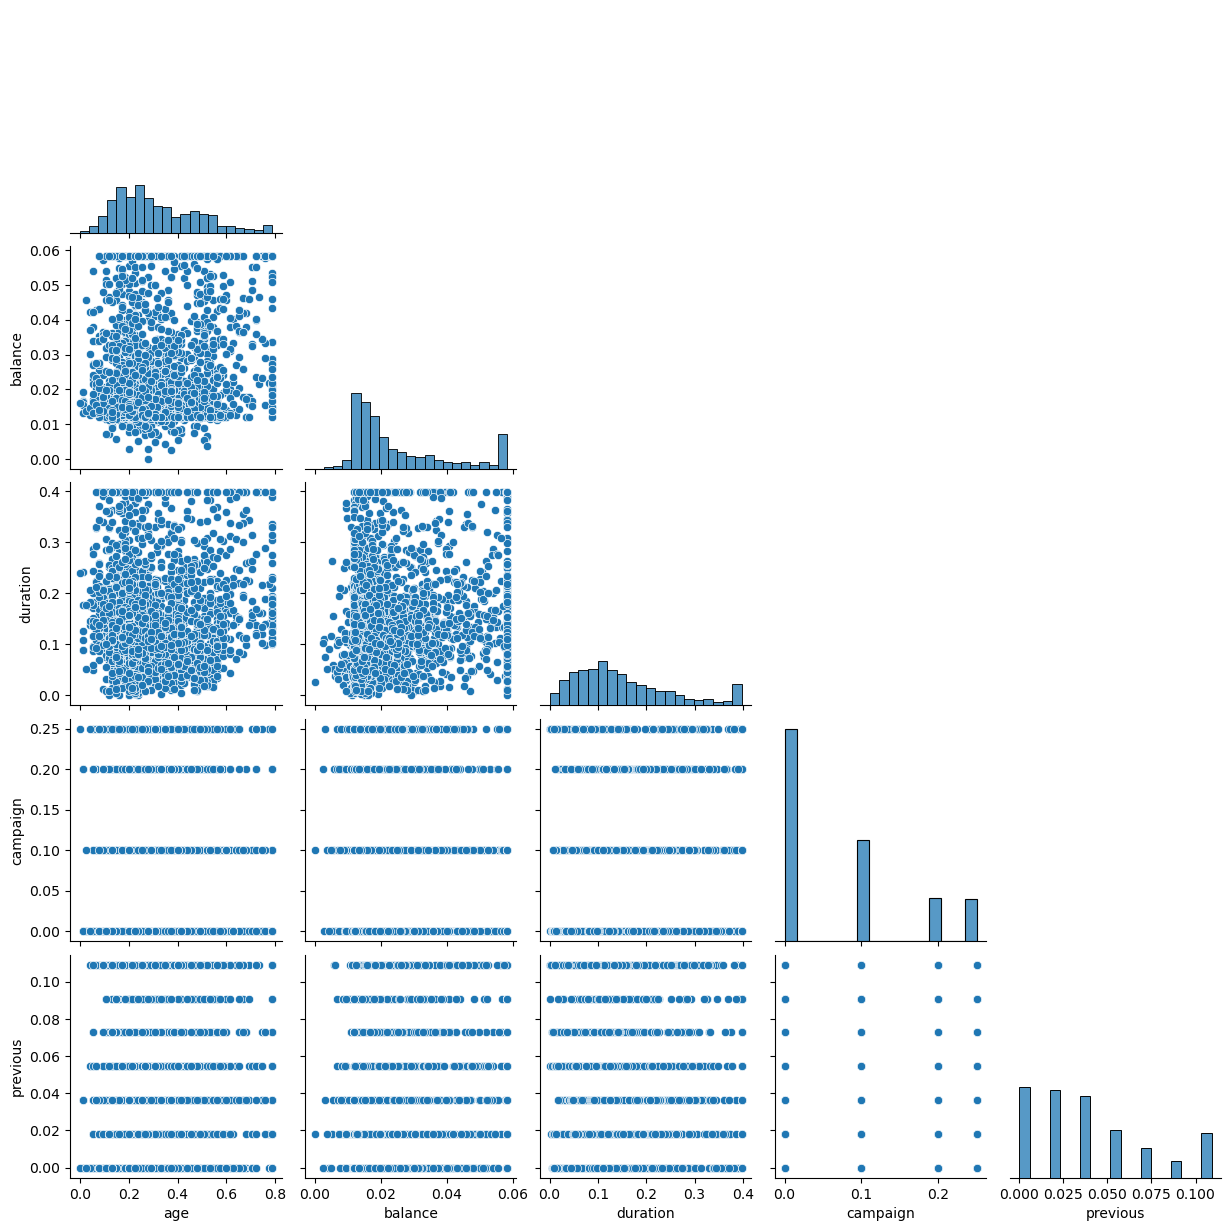

In [34]:
sns.pairplot(data=df_preprocessed[NUMERICAL_FEATURES], corner=True) # the original numericals after dropping two
plt.show()


In [35]:
skewness = df_preprocessed.skew(numeric_only=True)
kurtosis = df_preprocessed.kurtosis(numeric_only=True)
pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

Skewness    Kurtosis
age                   0.766185    0.017964
balance               1.174965    0.191810
duration              0.941769    0.214741
campaign              0.813956   -0.774439
previous              0.714789   -0.578004
job_admin.            2.290401    3.249183
job_blue-collar       1.972900    1.894228
job_entrepreneur      6.444358   39.569315
job_housemaid         7.364918   52.294312
job_management        1.280781   -0.359961
job_retired           3.073758    7.455442
job_self-employed     5.322174   26.351890
job_services          3.037263    7.232197
job_student           4.232093   15.926540
job_technician        1.721111    0.963185
job_unemployed        5.104931   24.084407
job_unknown          14.046385  195.496423
marital_divorced      2.536222    4.436857
marital_married      -0.223548   -1.951979
marital_single        0.690195   -1.525157
education_primary     2.519487    4.352166
education_secondary   0.010008   -2.001903
education_tertiary    0.666633   -1.557158
education_unknown     4.038574   14.324406
default_no          -11.425264  128.665327
default_yes          11.425264  128.665327
housing_no           -0.074106   -1.996506
housing_yes           0.074106   -1.996506
loan_no              -2.269489    3.153734
loan_yes              2.269489    3.153734
contact_cellular     -1.772590    1.143218
contact_telephone     3.285356    8.802368
contact_unknown       2.754663    5.593761
poutcome_failure      0.090159   -1.993866
poutcome_other        3.271211    8.709530
poutcome_success      1.338858   -0.207669
poutcome_unknown      1.304415   -0.298801
month_sin            -0.637790   -1.164549
month_cos             0.069918   -1.598988
day_sin              -0.362772   -1.295314
day_cos              -0.449210   -1.305533
cluster              -0.614645   -0.685638

Running the boxplot visualizations.

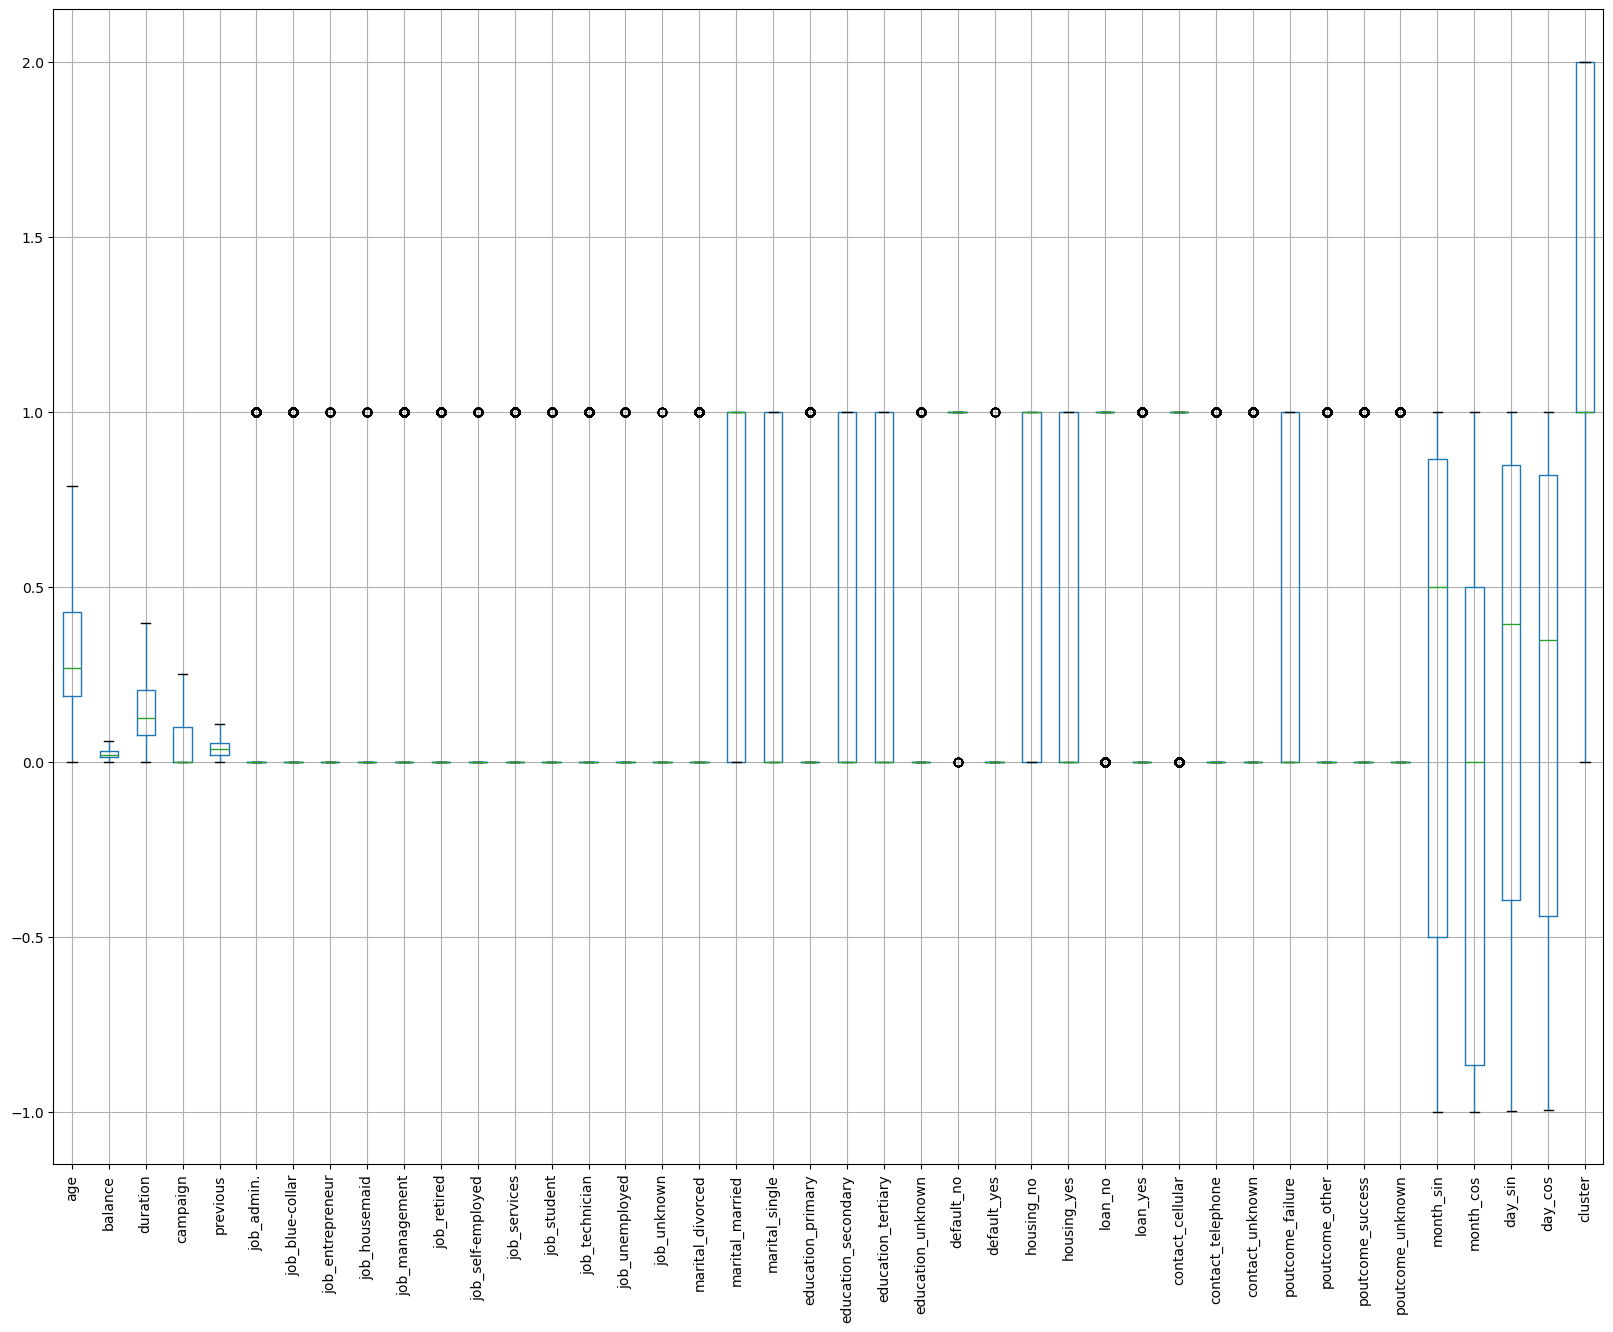

In [41]:
plt.figure(figsize=(20, 15)) 

df_preprocessed.boxplot(widths=0.5, rot=90)
#df_preprocessed.drop('cluster', axis=1).boxplot(widths=0.5, rot=90) # only needed if running out of order.

plt.show()

In [ ]:
# insert correlation here.
#corr_matrix = np.corrcoef(df_preprocessed)
#sns.heatmap(corr_matrix, cbar=True, cmap='coolwarm', linewidth=.5)
#plt.title('Correlation Matrix of Features after Pipeline')
#plt.show()

# the correlation plots are not different from when they were completed in Etivity One.

### Task Two - k-Means

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.

- Use the Silhouette Coefficient method to determine the best value of k as well.

- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.

- Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

In [8]:
# this is pulled straight from tutorial 2
#colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])
colors = np.array(['blue', 'yellow', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    '''The function clustering_scatterplot() creates the 2D scatter plot of the clustered dataset.'''   
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.ylabel('y')
    _ = plt.xlabel('x')

k-Means is determining the optimum number of clusters which the dataset can be split up into, in order to discover interesting patterns in the data. 



#### Elbow method for K

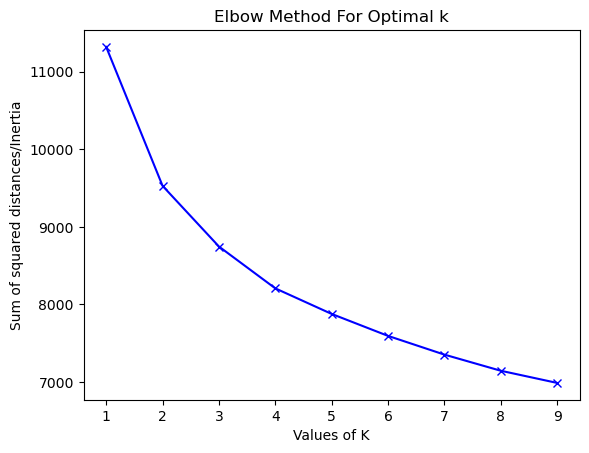

In [9]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# set to empty initially
Sum_of_squared_distances = []

K = range(1,10)
for num_clusters in K :
 kmeans = cluster.KMeans(n_clusters=num_clusters)
 kmeans.fit(df_preprocessed)
 Sum_of_squared_distances.append(kmeans.inertia_)

 
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()


The elbow method runs k-means clustering on the dataset for a range of values of k (say 1 to 10). In the elbow method, we plot mean distance and look for the elbow point where the rate of decrease shifts. For each k, calculate the total within-cluster sum of squares (WSS). This elbow point can be used to determine K.

#### Silhouette method for k

The Silhouette score is a measure of how similar a data point is within it's cluster compared to other clusters. It is defined in a range between -1 and 1, with 1 being the optimal value, ie, the point is far from other clusters. I will calculate the score for a range of k values, and see which one is the optimal k, ie, which one has the highest score.

For n_clusters=2, The Silhouette Coefficient is 0.14990105981909074
For n_clusters=3, The Silhouette Coefficient is 0.15870220837565568
For n_clusters=4, The Silhouette Coefficient is 0.15632408421857916
For n_clusters=5, The Silhouette Coefficient is 0.11546312001179342
For n_clusters=6, The Silhouette Coefficient is 0.11649106145864567
For n_clusters=7, The Silhouette Coefficient is 0.10982701055356242
For n_clusters=8, The Silhouette Coefficient is 0.11839494720988267
For n_clusters=9, The Silhouette Coefficient is 0.11862535432917158


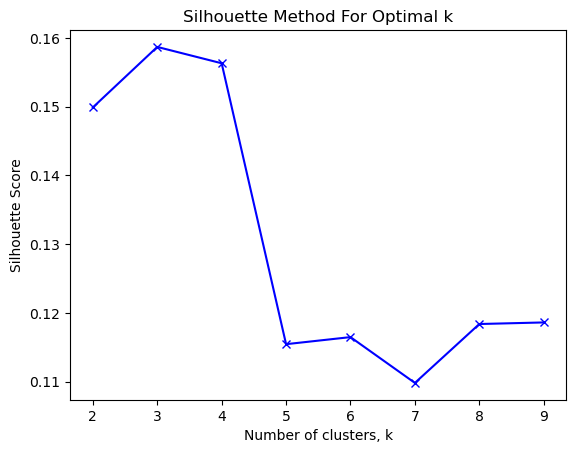

Optimal number of clusters: 3


In [10]:
silhouette_scores = []
K = range(2, 10)  # skip values k=1

for num_clusters in K:
    model = cluster.KMeans(n_clusters=num_clusters, random_state=0)
    labels = model.fit_predict(df_preprocessed)
    score = silhouette_score(df_preprocessed, labels)
    silhouette_scores.append(score)  
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(num_clusters, score))

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()


max_silhouette_score = float(max(silhouette_scores))
max_silhouette_score_index = silhouette_scores.index(max_silhouette_score)
optimal_num_clusters = K[max_silhouette_score_index]
print("Optimal number of clusters:", optimal_num_clusters)

#### Question: What is the best value of k for a k-Means clustering of the loans dataset? Why do you believe it is the best value of k and how have you found it or intend to find it?

I am using the elbow method to plot the values of K versus the sum of squared differences, the Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

The elbow here appears to be at k = 3, where the value drops sharply from where it was when k = 2. I am going to take the value as 3.

I also used the Silhouette technique, which also gives the same answer, k=3, corresponding to the maximum silhouette score from cluster numbers 1 through 10.

In [11]:
k = optimal_num_clusters  # chosen from both the elbow and the silhouette method above manually, and then i added this line.

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))     # or 20/40/60 - 100/200 # can I visualise multiple runs at the same time
])

# fitting the pipeline on a copy of the original data, after observing and testing above
df = pd.read_csv('bank.csv')
clustering_model = pipe.fit(df.copy())
clustering_model

/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('remove_outliers',
                                                                   RemoveOutliersTransformer())]),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'previous']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('cyc_pipeline',
                                                  Pipeline(steps=[('cyclical_encoder',
                                                                   CyclicalEncoder(day_period=31,
                                                                                   month_period=12)),
                                                                  ('passthrough',
                                                                   'passthrough')]),
                                                  ['month', 'day'])])),
                ('kMeans', KMeans(n_clusters=3, n_init=10))])

### E. Apply a manifold-learning technique to project the data set to a 2D space

In [12]:
data_and_centers = np.r_[df_preprocessed,clustering_model['kMeans'].cluster_centers_]

df_preprocessed.describe().T # sanity check

count      mean       std       min       25%  \
age                  2000.0  0.315914  0.166662  0.000000  0.186667   
balance              2000.0  0.024854  0.014549  0.000000  0.014376   
duration             2000.0  0.150211  0.099408  0.000000  0.076542   
campaign             2000.0  0.073700  0.090041  0.000000  0.000000   
previous             2000.0  0.039573  0.035012  0.000000  0.018182   
job_admin.           2000.0  0.123500  0.329093  0.000000  0.000000   
job_blue-collar      2000.0  0.149000  0.356178  0.000000  0.000000   
job_entrepreneur     2000.0  0.022500  0.148340  0.000000  0.000000   
job_housemaid        2000.0  0.017500  0.131158  0.000000  0.000000   
job_management       2000.0  0.230500  0.421258  0.000000  0.000000   
job_retired          2000.0  0.081000  0.272903  0.000000  0.000000   
job_self-employed    2000.0  0.032000  0.176044  0.000000  0.000000   
job_services         2000.0  0.082500  0.275194  0.000000  0.000000   
job_student          2000.0  0.048000  0.213820  0.000000  0.000000   
job_technician       2000.0  0.174000  0.379204  0.000000  0.000000   
job_unemployed       2000.0  0.034500  0.182555  0.000000  0.000000   
job_unknown          2000.0  0.005000  0.070551  0.000000  0.000000   
marital_divorced     2000.0  0.107500  0.309825  0.000000  0.000000   
marital_married      2000.0  0.555500  0.497034  0.000000  0.000000   
marital_single       2000.0  0.337000  0.472803  0.000000  0.000000   
education_primary    2000.0  0.108500  0.311089  0.000000  0.000000   
education_secondary  2000.0  0.497500  0.500119  0.000000  0.000000   
education_tertiary   2000.0  0.342000  0.474498  0.000000  0.000000   
education_unknown    2000.0  0.052000  0.222083  0.000000  0.000000   
default_no           2000.0  0.992500  0.086299  0.000000  1.000000   
default_yes          2000.0  0.007500  0.086299  0.000000  0.000000   
housing_no           2000.0  0.518500  0.499783  0.000000  0.000000   
housing_yes          2000.0  0.481500  0.499783  0.000000  0.000000   
loan_no              2000.0  0.875000  0.330802  0.000000  1.000000   
loan_yes             2000.0  0.125000  0.330802  0.000000  0.000000   
contact_cellular     2000.0  0.831500  0.374403  0.000000  1.000000   
contact_telephone    2000.0  0.073000  0.260202  0.000000  0.000000   
contact_unknown      2000.0  0.095500  0.293978  0.000000  0.000000   
poutcome_failure     2000.0  0.477500  0.499618  0.000000  0.000000   
poutcome_other       2000.0  0.073500  0.261021  0.000000  0.000000   
poutcome_success     2000.0  0.222000  0.415695  0.000000  0.000000   
poutcome_unknown     2000.0  0.227000  0.418997  0.000000  0.000000   
month_sin            2000.0  0.218295  0.685899 -1.000000 -0.500000   
month_cos            2000.0 -0.073473  0.690627 -1.000000 -0.866025   
day_sin              2000.0  0.200956  0.659767 -0.998717 -0.394356   
day_cos              2000.0  0.185124  0.700368 -0.994869 -0.440394   

                              50%       75%       max  
age                  2.666667e-01  0.426667  0.786667  
balance              1.862893e-02  0.031934  0.058272  
duration             1.261013e-01  0.204846  0.397302  
campaign             0.000000e+00  0.100000  0.250000  
previous             3.636364e-02  0.054545  0.109091  
job_admin.           0.000000e+00  0.000000  1.000000  
job_blue-collar      0.000000e+00  0.000000  1.000000  
job_entrepreneur     0.000000e+00  0.000000  1.000000  
job_housemaid        0.000000e+00  0.000000  1.000000  
job_management       0.000000e+00  0.000000  1.000000  
job_retired          0.000000e+00  0.000000  1.000000  
job_self-employed    0.000000e+00  0.000000  1.000000  
job_services         0.000000e+00  0.000000  1.000000  
job_student          0.000000e+00  0.000000  1.000000  
job_technician       0.000000e+00  0.000000  1.000000  
job_unemployed       0.000000e+00  0.000000  1.000000  
job_unknown          0.000000e+00  0.000000  1.000000  
marital_divorced     0.000000e+

#### E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

Multi-Dimensional Scaling is a low dimensional representation of the data where the distances respect well the original distances in the data. It is used in general for analyzing similarity (or dissimilarity). 

In [13]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)

print("transformation complete") # around 50seconds



transformation complete


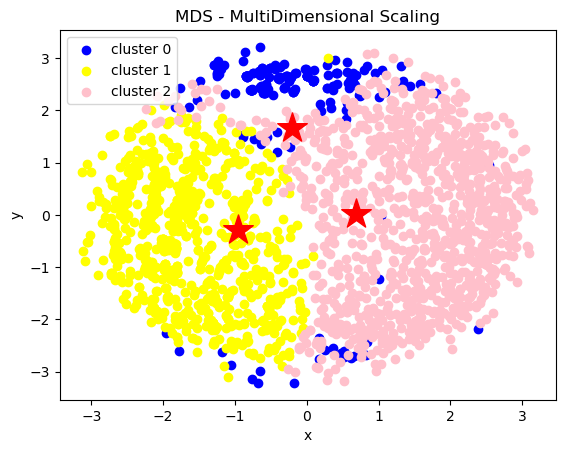

In [14]:
#  Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS - MultiDimensional Scaling')


 #### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

t-SNE (t-distributed Stochastic Neighbor Embedding) is a popular technique for dimensionality reduction, in this case into a 2D space, of very high dimensional data. It models similarities between data points in the high dimensional space, and then their corresponding similarities in the low dimensional space. This clusters the points into clusters of 'similar' data points, in a way we can visualise it. 

In [15]:
# Projecting both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


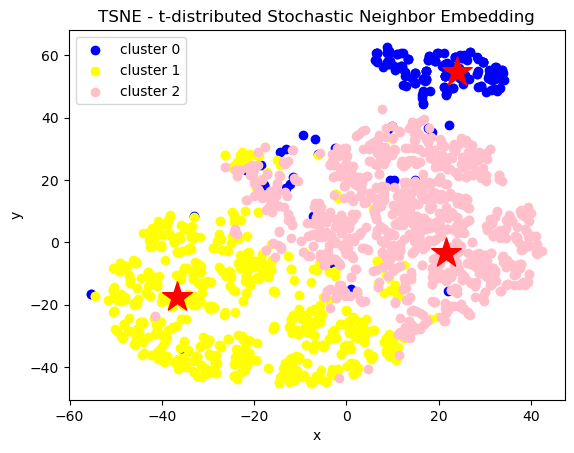

In [16]:
#  Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.
# Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. 
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE - t-distributed Stochastic Neighbor Embedding')

In [17]:
#  Add the cluster labels as an extra column in the original dataframe
df_preprocessed['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df_preprocessed.index)
df_preprocessed.head()

age   balance  duration  campaign  previous  job_admin.  \
0  0.186667  0.016694  0.397302       0.1  0.036364         0.0   
1  0.280000  0.020296  0.124449       0.1  0.018182         0.0   
2  0.546667  0.024518  0.065529       0.1  0.018182         0.0   
3  0.386667  0.016767  0.147026       0.0  0.036364         0.0   
4  0.480000  0.024141  0.259912       0.0  0.018182         0.0   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
0              0.0               0.0            0.0             0.0  ...   
1              0.0               0.0            0.0             0.0  ...   
2              0.0               0.0            0.0             0.0  ...   
3              1.0               0.0            0.0             0.0  ...   
4              0.0               0.0            0.0             0.0  ...   

   contact_unknown  poutcome_failure  poutcome_other  poutcome_success  \
0              0.0               1.0             0.0               0.0   
1              0.0               1.0             0.0               0.0   
2              0.0               1.0             0.0               0.0   
3              0.0               1.0             0.0               0.0   
4              0.0               1.0             0.0               0.0   

   poutcome_unknown  month_sin  month_cos   day_sin  day_cos  cluster  
0               0.0   0.866025       -0.5  0.201299  0.97953        1  
1               0.0   0.866025       -0.5  0.201299  0.97953        1  
2               0.0   0.866025       -0.5  0.201299  0.97953        1  
3               0.0   0.866025       -0.5  0.201299  0.97953        1  
4               0.0   0.866025       -0.5  0.201299  0.97953        1  

[5 rows x 42 columns]

In [18]:
# examine the df now that the clusters are added.
df_preprocessed.select_dtypes(exclude=['object']).groupby('cluster').mean()

age   balance  duration  campaign  previous  job_admin.  \
cluster                                                                 
0        0.282617  0.020616  0.126948  0.054673  0.003144    0.088785   
1        0.310878  0.021664  0.113368  0.080049  0.044731    0.134639   
2        0.327513  0.028481  0.186413  0.072549  0.043269    0.121775   

         job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
cluster                                                                     
0               0.322430          0.023364       0.014019        0.140187   
1               0.198286          0.028152       0.014688        0.197062   
2               0.069143          0.017544       0.020640        0.278638   

         ...  contact_telephone  contact_unknown  poutcome_failure  \
cluster  ...                                                         
0        ...           0.051402         0.869159          0.000000   
1        ...           0.064871         0.000000          0.969400   
2        ...           0.084623         0.005160          0.168215   

         poutcome_other  poutcome_success  poutcome_unknown  month_sin  \
cluster                                                                  
0              0.042056          0.018692          0.939252   0.450599   
1              0.014688          0.007344          0.008568   0.684970   
2              0.130031          0.447884          0.253870  -0.226480   

         month_cos   day_sin   day_cos  
cluster                                 
0        -0.814087  0.860885 -0.047073  
1         0.469824  0.211329  0.643918  
2        -0.367986  0.046467 -0.150422  

[3 rows x 41 columns]

- Clusters clearly characterised in a markdown cell.




In [ ]:
# cluster 0 - age 45, cluster 1 - 40.7, cluster 2 - 39.2
# now I have rescaled cluster 0 - age 0.29, cluster 1 - 0.18, cluster 2 - 0.57

##### Question: Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters

For both visualizations, K-means clustering is clustering the data into three clusters. 

I think the clusters can be summarized as

* Those likely to subscribe who actually subscribed after the phonecall
* Those unlikely to subscribe who didn't subscribe after the phonecall
* Those who were far from the two extremes, but had other slightly correlated features similar to each other (job, marital)

In the MDS clustering there are almost cyclical like results, with each of the three centres being close to a third of a circle, a third of the way around. In the TSNE, the top cluster is closer together, and has now shifted to the right.

In the above breakdown I was attempting to see the ages of each cluster, to see if that looked like the most dominant of the features, which I suspected it was initially, but now I can see that it is more complex than that. There are strong correlations between some jobs, some age groups, some education groups, and some balance figures, which as I mentioned in E-1, in some way form kind of a class structure clustering. Those in the highest class would be those likely to subscribe, those in the lowest class would be the least likely to subscribe, and those in the middle class (or classes) would be the cluster in the middle. I would consider grouping some more of the features into bins to see if I would be able to elaborate on this a little more if I had more time.

### Task Three - DBSCAN

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.

- Use MDS and t-SNE for visualising the clustering. Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

#### Question: Have you found a good DBSCAN clustering? With what parameters?

No I have not, as I outlined below. I began with the HyperParameters which were given for the iris dataset, and initially it appeared that I had received some good clustering results. After changing the pipeline, and adjusting the epsilon value, my clusters began to become more and more inaccurate, with most of the points classified as noise.

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density

In [19]:
# https://scikit-learn.org/stable/modules/clustering.html
## Pipeline and Clustering

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('dbscan', cluster.DBSCAN(eps=0.3, min_samples=10))
])

# fit pipeline
df = pd.read_csv('bank.csv')
clustering_model = pipe.fit(df) # is it ok also calling this clustering model?
clustering_model


/Applications/anaconda3/envs/CS5062/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('remove_outliers',
                                                                   RemoveOutliersTransformer())]),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'previous']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('cyc_pipeline',
                                                  Pipeline(steps=[('cyclical_encoder',
                                                                   CyclicalEncoder(day_period=31,
                                                                                   month_period=12)),
                                                                  ('passthrough',
                                                                   'passthrough')]),
                                                  ['month', 'day'])])),
                ('dbscan', DBSCAN(eps=0.3, min_samples=10))])

In [20]:
preprocessed_DBSCAN = clustering_model.named_steps['preprocess'].transform(df)

In [22]:
def DBSCAN_clustering_scatterplot(points, labels, title):
    '''This function will plot the scatterplot for DBSCAN clustering'''
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    for i in range(n_clusters):
        if i == -1:
            color = 'black'
            label = 'noise'
        else:
            color = colors[i % colors.size]
            label = 'cluster ' + str(i)
        h = plt.scatter(points[labels == i, 0],
                        points[labels == i, 1], 
                        c=color,
                        label=label)
    
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [21]:
# declare the labels for both below plots
labels_DBSCAN = clustering_model.named_steps['dbscan'].labels_

#### DBSCAN Algorithm - MDS

In [23]:
# Apply a manifold-learning technique to project the data set to a 2D space

XYcoordinates_mds = manifold.MDS(n_components=2, random_state=0).fit_transform(preprocessed_DBSCAN)
print("transformation complete") # around 50s

transformation complete


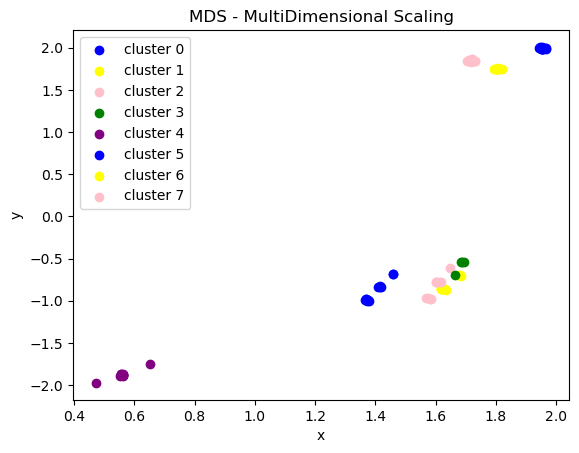

In [24]:
# plot the clusters
DBSCAN_clustering_scatterplot(points=XYcoordinates_mds, 
                             labels=labels_DBSCAN, 
                             title='MDS - MultiDimensional Scaling')


I can see that there are Eight clusters here, but three of them in the top right corner are very close to each other, and four of them in the middle lower are also very close to each other. This indicates to me that I suspect the number of clusters is likely to be three, and that I have chosen incorrect or unsuitable hyperparameters in order to obtain optimal clustering. I have changed them a number of times, and this is the most coherent clustering I have found. If i had some additional time I would try to tweak them further in a way where the clustering may be tighter, with less clusters, maybe by tweaking the way I dealt with outliers in the data, or the scalers I used.

#### DBSCAN Algorithm - T-SNE

In [25]:
# Apply a manifold-learning technique to project the data set to a 2D space

XYcoordinates_TSNE = manifold.TSNE(n_components=2, random_state=0).fit_transform(preprocessed_DBSCAN)
print("transformation complete") # around 5s

transformation complete


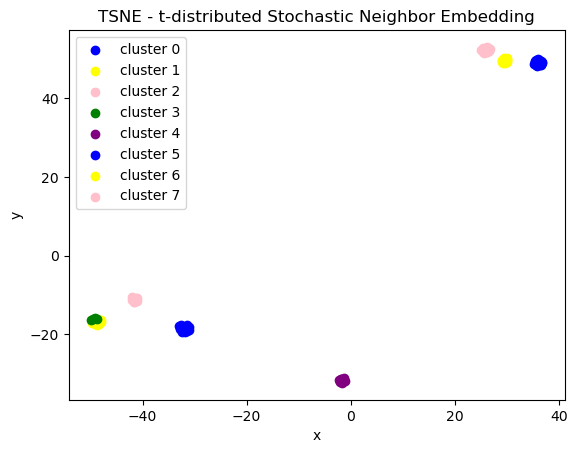

In [26]:
# plot the clusters
DBSCAN_clustering_scatterplot(points=XYcoordinates_TSNE, 
                             labels=labels_DBSCAN, 
                             title='TSNE - t-distributed Stochastic Neighbor Embedding')

Again, like the above example, the number of cluster identified is 8, with three clusters in the top right hand corner indicating they may be misclassified and may be one cluster, one cluster in the middle lower, and four clusters in the bottom left hand corner. Again, I suspect this is due to my choice of hyperparameters, or the scalers, or how I treated or mistreated the outliers in the pipeline. I was hoping for three very clear tight clusters, as indicated by the k-means analysis above.

In [30]:

centers = [[1, 1], [-1, -1], [1, -1]]
preprocessed_DBSCAN, labels_true = make_blobs(
    n_samples=2000, centers=centers, cluster_std=0.4, random_state=0
)

# clustering
db = preprocessed_DBSCAN  ## db = cluster.DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = labels_DBSCAN

# Evaluate clustering performance
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(db, labels):.3f}")



Estimated number of clusters: 8
Estimated number of noise points: 1909
Homogeneity: 0.003
Completeness: 0.013
V-measure: 0.005
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: -0.221


https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation

Two very important scores, and indicators whether I should continue to tweak the hyperparameters are the Homogeneity, and the Completeness. Both are close to 0, indicating that I need to change the hyperparameters, something that I did on a number of occasions, but ran into even worse results.

The V-measure score is referred to as the harmonic mean of both, with more mean being attributed to the completeness. This measure is also almost zero with that being the lower bound, indicating an issue with the accuracy of the clustering.

I believe that this is due to me either inaccurately scaling the numerical features in section one through the pipelines, or correct removal of outliers from the data in said same section, considering I struggled to find hyperparameters which ran much better.


### Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters

The combination of the low cluster scores here indicate very weak clustering, and that 95% of the points here are categorized as noise points. Many of the clusters are close together, indicating to me that they may share many similarities in many of the features with each other, but are being categorized as different clusters due to one or two 'important' clusters. As I mentioned above, I believe instead of 8 clusters there should be three.

To compare DBSCAN to Kmeans as a clustering model, I feel that Kmeans does a better job at identifying clusters, as I was able to use two different techniques to estimate the best value for K, the number of clusters, and then I was able to see exactly how changing the pipeline of the data would affect the clusters. In this case I was able to achieve much better results with Kmeans, maybe because of this. DBSCAN is more susceptible to poor results due to poor choice of hyperparameters, something which I think I made the error of here, and not having enough time to implement something like cross-validation in order to pick better hyper-parameters.

I think the clusters can be summarized as (similar to above)

* Those likely to subscribe who actually subscribed after the phonecall
* Those unlikely to subscribe who didn't subscribe after the phonecall
* Those who were far from the two extremes, but had other slightly correlated features similar to each other (job, marital)

In the case of the Eight clusters, I think there were sub clusters around ages similar to each other or balances/jobs similar to each other. This might be shown if I edited the pipeline, and included some more bins to group these features.


#### Appendices
Includes some incomplete unused code

In [ ]:
# Appendix One

# this is from the Optional Material for week 11. Can use to plot k-means elbow & Silhouette simultaneously.

range_n_clusters = [2, 3, 4, 5, 6,7,8]
elbow = []
ss = []
for n_clusters in range_n_clusters:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(df1)
   #Finding the average silhouette score
   silhouette_avg = silhouette_score(df1, cluster_labels)
   ss.append(silhouette_avg)
   print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)`
   #Finding the average SSE"
   elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [33]:
## Appendix Two

# plotting the DBSCAN clusters
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'core_sample_indices_'